### Notes:
- #### Images are stored as tensors: (height, width, RGB vector)
    - 0=Red, 1=Green, 2=Blue
    - 1920x1454x3 = 8375040
- Quntifying color difference by sum of squared differences in RGB space
- Optimization:
    - Numba JIT compilation
    - Flatten arrays and use linear indexing because each configuration swaps only one pixel
    - float32
    - Vectorized calculations

### Prelims and Data Handling

In [1]:
import numpy as np
from numba import jit
from PIL import Image
import matplotlib.pyplot as plt
import time

In [2]:
def load_images(file_src, file_tgt):
    """
    Load source and target images, ensure same size, return flattened arrays
    Returns the two images and the shape of the initial arrays for backwards reconstruction
    """
    
    print(f"Reading images: source={file_src}, target={file_tgt}")
    
    # Open images
    src_image = Image.open(file_src).convert('RGB')
    tgt_image = Image.open(file_tgt).convert('RGB')
    
    # Check dimensions match
    if src_image.size != tgt_image.size:
        raise ValueError("Images do not have the same dimensions.")
    
    print(f"Pixel Geometry: {src_image.width} x {src_image.height}")
    numPix = src_image.width * src_image.height
    print(f"Total pixels: {numPix}")
    
    # Convert to numpy arrays
    # Original image array shape: (1454, 1920, 3) for source1, (1286, 1920, 3) for source2
    #   - 1454 rows (height)
    #   - 1920 columns (width)  
    #   - 3 color channels (R, G, B)
    src_array = np.array(src_image)
    tgt_array = np.array(tgt_image)
    
    # Flatten to 2D (numPixels, 3) array and convert to float32
    # Flattened shape: (2,791,680, 3)
    #   - 2,791,680 rows (one per pixel, 1454×1920)
    #   - 3 columns (R, G, B)
    src_flat = src_array.reshape(-1, 3).astype(np.float32)
    tgt_flat = tgt_array.reshape(-1, 3).astype(np.float32)
    
    return src_flat, tgt_flat, src_array.shape

In [84]:
file_src = "source1.png"
file_tgt = "target1.png"

In [70]:
#file_src = "source2.png"
#file_tgt = "target2.png"

In [85]:
src_flat, tgt_flat, original_shape = load_images(file_src, file_tgt)

Reading images: source=source1.png, target=target1.png
Pixel Geometry: 1920 x 1454
Total pixels: 2791680


In [86]:
print(f"Array shapes:")
print(f"  src_flat: {src_flat.shape}")
print(f"  tgt_flat: {tgt_flat.shape}")
print(f"  original_shape (H, W, C): {original_shape}")

Array shapes:
  src_flat: (2791680, 3)
  tgt_flat: (2791680, 3)
  original_shape (H, W, C): (1454, 1920, 3)


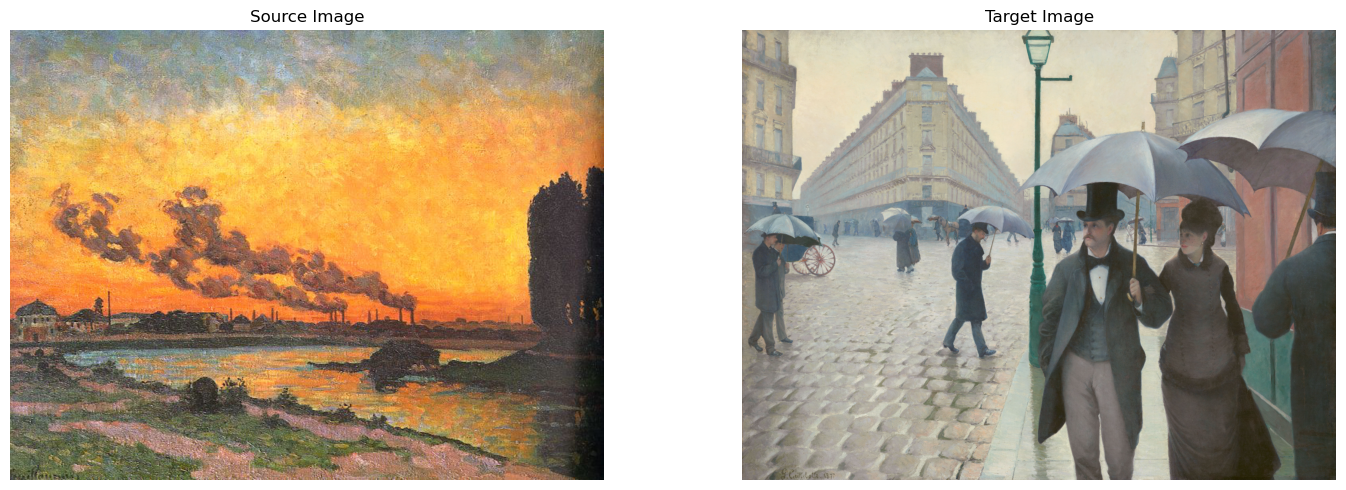

In [87]:
# Reshape flattened arrays back to images
src_img = src_flat.reshape(original_shape).astype(np.uint8)
tgt_img = tgt_flat.reshape(original_shape).astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(src_img)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(tgt_img)
axs[1].set_title('Target Image')
axs[1].axis('off')

plt.tight_layout()

### Practice for my sake

In [47]:
src_flat

array([[123., 144., 169.],
       [128., 150., 175.],
       [130., 152., 179.],
       ...,
       [145., 160., 150.],
       [142., 148., 139.],
       [136., 139., 129.]], shape=(2469120, 3), dtype=float32)

In [48]:
# out_flat.shape = (2791680, 3)
src_flat[345]          # Shape (3,) - one pixel's RGB values

array([140., 156., 186.], dtype=float32)

In [226]:
# Same thing - [R, G, B]
src_flat[345, :]

array([106., 134., 142.], dtype=float32)

In [227]:
# Just the Green value
src_flat[345, 1]

np.float32(134.0)

### Calculations

In [88]:
@jit(nopython=True)
def color_diff_squared(pix1, pix2):
    """Squared Euclidean distance between two RGB pixels
       pix1, pix2 are arrays of shape (3,) containing [R, G, B]"""
    dr = pix1[0] - pix2[0]
    dg = pix1[1] - pix2[1]
    db = pix1[2] - pix2[2]
    return dr*dr + dg*dg + db*db

In [89]:
@jit(nopython=True)
def total_energy(src_flat, tgt_flat):
    """Calculate total energy (squared color difference) between two inputted arrays
       Sum over all pixels of squared RGB distance"""
    total = 0.0
    n = len(src_flat)
    for i in range(n):
        total += color_diff_squared(src_flat[i], tgt_flat[i])
    return total

In [90]:
@jit(nopython=True)
def energy_change_from_swap(src_flat, tgt_flat, i, j):
    """Calculate change in color distance if pixels i and j were swapped      
       Current state: src[i] at position i, src[j] at position j
       After swap:    src[j] at position i, src[i] at position j
    """
    # Old energy contribution from positions i and j
    old_E = color_diff_squared(src_flat[i], tgt_flat[i]) + color_diff_squared(src_flat[j], tgt_flat[j])
    
    # New energy contribution after swap
    new_E = color_diff_squared(src_flat[j], tgt_flat[i]) + color_diff_squared(src_flat[i], tgt_flat[j])
    
    return new_E - old_E

In [91]:
initial_energy = total_energy(src_flat, tgt_flat)
print(f"Initial energy: {initial_energy:.2e}")

# Test a single swap
i, j = 1000, 5000
deltaE = energy_change_from_swap(src_flat, tgt_flat, i, j)
print(f"Energy change from swapping pixels {i} and {j}: {deltaE:.2f}")

Initial energy: 4.15e+10
Energy change from swapping pixels 1000 and 5000: -32.00


### Algorithm

In [92]:
@jit(nopython=True)
def metropolis(out_flat, tgt_flat, T0, nsweeps):
    """
    Recursive function that applie metrolopis algorithm to lower energy
    
    Parameters:
      out_flat: array shape (numPixels, 3)
        - Current arrangement of source pixels (to be modified in place)
      tgt_flat: array shape (numPixels, 3)
        - Target image pixels (fixed reference)
      T: float
        - Temperature for Metropolis acceptance
      nsweeps: int
        - Number of swap attempts at this temperature
        
    Returns:
    current_energy: float
        Energy after nsweeps at temperature T
    """
    
    n = len(out_flat)
    #current_energy = total_energy(out_flat, tgt_flat)
    
    for _ in range(nsweeps):
        # Pick two random pixels to swap
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)
        
        # Skip if same pixel
        if i == j:
            continue
        
        # Calculate energy change from this swap
        deltaE = energy_change_from_swap(out_flat, tgt_flat, i, j)
        
        # Metropolis acceptance criterion
        if deltaE < 0 or np.exp(-deltaE/T0) > np.random.random():
            # Accept: perform the swap of all three RGB values
            ith_element = out_flat[i].copy()
            out_flat[i] = out_flat[j].copy()
            out_flat[j] = ith_element
            #current_energy += deltaE
        # else: reject, do nothing (keep current configuration)
    
    return out_flat

In [93]:
# Initialize the output array
out_flat = src_flat.copy()

# Run metropolis
T_test = 1000.0
nsweeps_test = 1000000

initial_energy = total_energy(src_flat, tgt_flat)
out_flat = metropolis(out_flat, tgt_flat, T_test, nsweeps_test)
final_energy = total_energy(out_flat, tgt_flat)

print(f"Initial energy: {initial_energy:.2e}")
print(f"Final energy: {final_energy:.2e}")
print(f"Energy reduction: {initial_energy - final_energy:.2e}")

Initial energy: 4.15e+10
Final energy: 3.73e+10
Energy reduction: 4.24e+09


In [94]:
def simulated_annealing(src_flat, tgt_flat, T0, nsweeps_per_temp, min_temp=0.1):
    """
    Run simulated annealing, metropolis function at each temperature
    
    Parameters:
      src_flat: array shape (numPixels, 3)
        - Arrangement of source pixels
      tgt_flat: array shape (numPixels, 3)
        - Arrangement of target image pixels
      T: float
        - Initial temperature
      nsweeps_per_temp: int
        - Number of swap attempts at each temperature

    Returns:
      out_flat: array
        - Final arrangement of source pixels that best matches target pixels
    """
    
    # Calculate initial distance
    initial_energy = total_energy(src_flat, tgt_flat)
    print(f"Initial energy: {initial_energy:.2e}")
    
    # Now implement annealing schedule

    # Initialize stuff
    T = T0
    current_energy = initial_energy
    out_flat = src_flat.copy()
    
    while T > min_temp:
        # Run Metropolis at this temperature, redines route each time
        out_flat = metropolis(out_flat, tgt_flat, T, nsweeps_per_temp)
        T *= 0.9
    
    # Final distance at the finalized route
    final_energy = total_energy(out_flat, tgt_flat)

    
    print(f"Final energy: {final_energy:.2e}")
    print(f"Energy reduction: {initial_energy - final_energy:.2e} ({100*(initial_energy-final_energy)/initial_energy:.1f}%)")

    return out_flat

In [98]:
%%time
out_flat_final = simulated_annealing(src_flat, tgt_flat, T0=500, nsweeps_per_temp=1000000, min_temp=0.001)

Initial energy: 4.15e+10
Final energy: 1.49e+10
Energy reduction: 2.66e+10 (64.1%)
CPU times: user 20.7 s, sys: 993 μs, total: 20.7 s
Wall time: 21.3 s


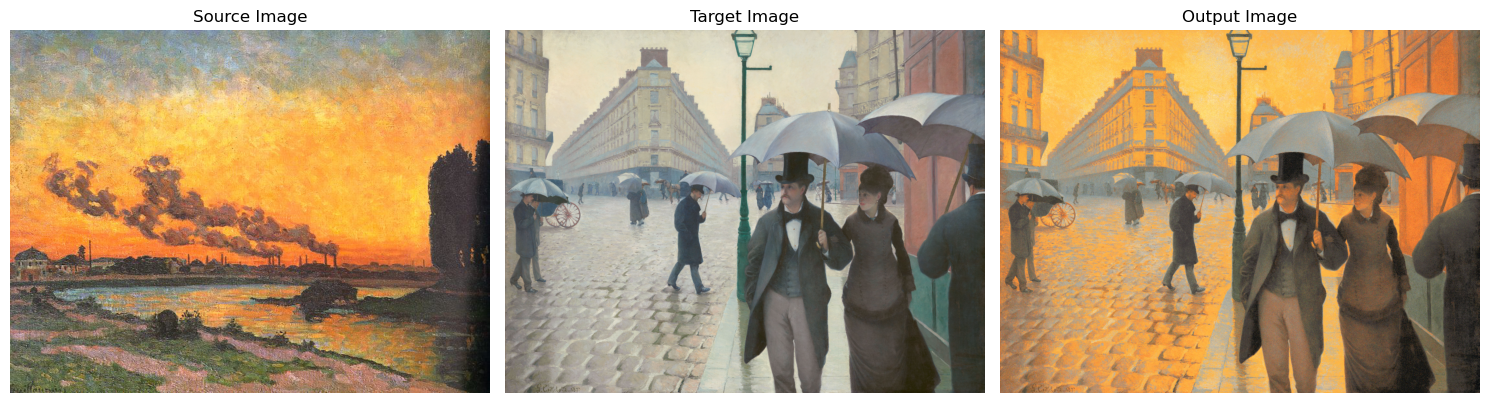

In [100]:
# Reshape flattened arrays back to images
src_img = src_flat.reshape(original_shape).astype(np.uint8)
tgt_img = tgt_flat.reshape(original_shape).astype(np.uint8)
out_img = out_flat_final.reshape(original_shape).astype(np.uint8)

# plot the pixels
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(src_img)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(tgt_img)
axs[1].set_title('Target Image')
axs[1].axis('off')

axs[2].imshow(out_img)
axs[2].set_title('Output Image')
axs[2].axis('off')

plt.tight_layout()

plt.savefig("FINAL1.png", dpi=150, bbox_inches='tight')
#plt.savefig("FINAL2.png", dpi=150, bbox_inches='tight')    